## Import Dependencis

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

## Loading Data

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset = image_dataset_from_directory(directory="PlantVillage",
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         image_size=(IMAGE_SIZE, IMAGE_SIZE))

TypeError: Unknown keywords argument(s): ('rescale', 'horizontal_flip', 'rotation_range')

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) * BATCH_SIZE

2176

In [6]:
# Let's explore our data 
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape, label_batch.numpy(), sep="\n")

(32, 256, 256, 3)
[1 0 1 0 1 1 1 1 1 2 0 0 0 1 0 0 2 0 1 0 0 1 1 0 1 0 0 1 2 1 1 0]


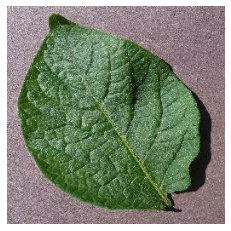

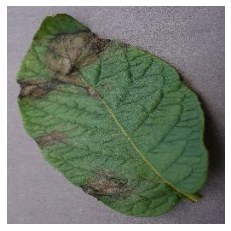

In [9]:
# To visualize one image : 2 ways 
plt.imshow(images[0]/255.)
plt.axis("off")
plt.show()
plt.imshow(image_batch[0].numpy().astype("uint16"))
plt.axis("off")
plt.show()

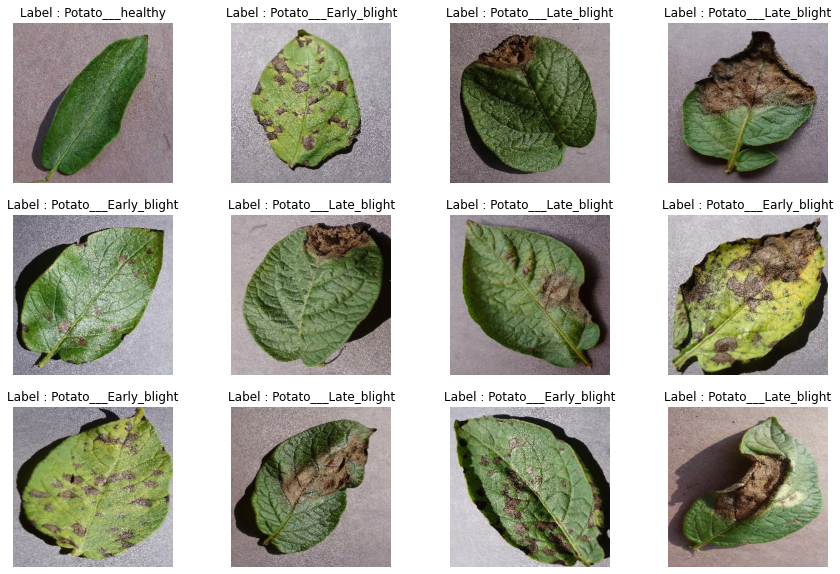

In [8]:
# Let's visualize a random samples of our train set
random_index = random.sample(range(0, 32), 12)
first_batch = dataset.as_numpy_iterator().next()
images, labels = first_batch

plt.figure(figsize=(15, 10))
for i, j in zip(random_index, range(12)):
    ax = plt.subplot(3, 4, j+1)
    plt.title(f"Label : {class_names[labels[i]]}")
    plt.imshow(images[i]/255.)
    plt.axis("off")

## Split dataset into Training(80 %) , Validation(10 %) and Testing(10 %) Sets 

In [68]:
# Split dataset into Training(80 %) , Validation(10 %) and Testing(10 %) Sets 

train_size = np.round(len(dataset) * 0.8)
val_size = np.round(len(dataset) * 0.1)
test_size = np.round(len(dataset) * 0.1)

print(train_size + val_size + test_size == len(dataset))
train_size, val_size, test_size, test_size

True


(54.0, 7.0, 7.0, 7.0)

In [69]:
train_data = dataset.take(train_size)
test_val_data = dataset.skip(train_size)
val_data = test_val_data.take(val_size)
test_data = test_val_data.skip(val_size)

len(dataset), len(train_data), len(val_data), len(test_data)

(68, 54, 7, 7)

In [10]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = np.round(dataset_size * train_split)
    val_size = np.round(dataset_size * val_split)
    
    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

In [11]:
train_data, val_data, test_data = get_dataset_partitions_tf(dataset=dataset)
len(train_data), len(val_data), len(test_data)

(54, 7, 7)

In [13]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing : Rescaling, Resizing and data Augmentation

In [22]:
# Let's create a rescale and resize layer
from tensorflow.keras.models import Sequential
rescale_resize_layer = Sequential([
            layers.experimental.preprocessing.Rescaling(scale=1./255),
            layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [23]:
# Let's create our data augmentation layer

data_augmentation_layer = Sequential([
            layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
            layers.experimental.preprocessing.RandomRotation(factor=0.2)
])

(900, 600, 3)
(256, 256, 3)
(256, 256, 3)


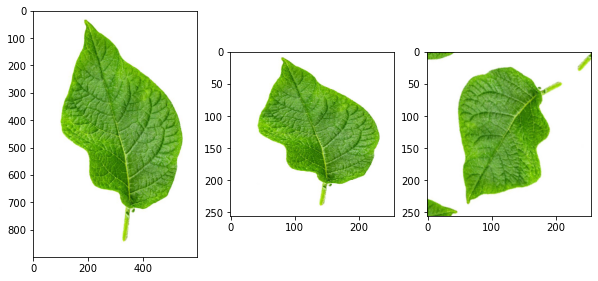

In [33]:
# Let's test our 2 prepprocessing layer on a new image

new_img = plt.imread("test_health.jpg")
print(new_img.shape)
plt.figure(figsize=(10, 7))
img_rescaled_resized = rescale_resize_layer(new_img)
print(img_rescaled_resized.shape)
img_augmented = data_augmentation_layer(img_rescaled_resized)
print(img_augmented.shape)
plt.subplot(131)
plt.imshow(new_img)
plt.subplot(132)
plt.imshow(img_rescaled_resized)
plt.subplot(133)
plt.imshow(img_augmented)
plt.show()

## Model Architecture

In [218]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    rescale_resize_layer,
    data_augmentation_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=input_shape)

In [219]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (256, 256, 3)             0         
_________________________________________________________________
sequential_1 (Sequential)    (256, 256, 3)             0         
_________________________________________________________________
conv2d_90 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_91 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_92 (Conv2D)           (32, 60, 60, 64)        

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [220]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [221]:
# Fit the model 

history = model.fit(train_data,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_data=val_data)

Epoch 1/10
54/54 [==============================] - 152s 3s/step - loss: 0.8962 - accuracy: 0.5197 - val_loss: 0.8695 - val_accuracy: 0.5134
Epoch 2/10
54/54 [==============================] - 145s 3s/step - loss: 0.6615 - accuracy: 0.7286 - val_loss: 0.6393 - val_accuracy: 0.6964
Epoch 3/10
54/54 [==============================] - 144s 3s/step - loss: 0.4721 - accuracy: 0.7986 - val_loss: 0.3947 - val_accuracy: 0.8393
Epoch 4/10
54/54 [==============================] - 145s 3s/step - loss: 0.3317 - accuracy: 0.8738 - val_loss: 0.2615 - val_accuracy: 0.9018
Epoch 5/10
54/54 [==============================] - 145s 3s/step - loss: 0.2360 - accuracy: 0.9068 - val_loss: 0.2047 - val_accuracy: 0.9152
Epoch 6/10
54/54 [==============================] - 145s 3s/step - loss: 0.2250 - accuracy: 0.9062 - val_loss: 0.7982 - val_accuracy: 0.7232
Epoch 7/10
54/54 [==============================] - 143s 3s/step - loss: 0.2445 - accuracy: 0.9039 - val_loss: 0.3460 - val_accuracy: 0.8839
Epoch 8/10
54

In [222]:
scores = model.evaluate(test_data)
scores

7/7 [==============================] - 5s 733ms/step - loss: 0.1820 - accuracy: 0.9196


[0.18203140795230865, 0.9196428656578064]

## Save the Model

In [223]:
tf.keras.models.save_model(model, "1stmodel.h5")

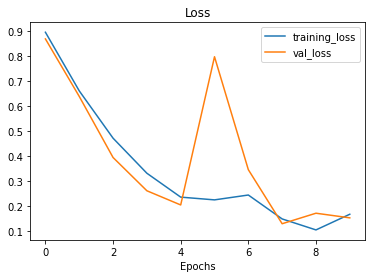

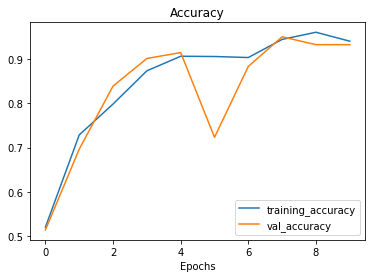

In [224]:
from helper_functions import plot_loss_curves, make_confusion_matrix
plot_loss_curves(history)

## Model Evaluation : Metrics & Confusion Matrix

In [225]:
pred_probs = model.predict(test_data,verbose=1)
# How many predictions are there?
print(len(pred_probs), len(test_data) * 32)
# What's the shape of our predictions?
pred_probs.shape

7/7 [==============================] - 5s 630ms/step
224 224


(224, 3)

In [226]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)
# How do they look?
pred_classes[:10], len(pred_classes)

(array([1, 1, 0, 1, 0, 0, 1, 1, 1, 2], dtype=int64), 224)

In [227]:
# Let's grab our real labels from test_data
labels =  []

for x, y in test_data:
    labels.append(list(y.numpy()))
labels = np.array(labels)
labels = labels.flatten()
labels

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1])

In [228]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(labels)

224

In [229]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(labels, pred_classes)
sklearn_accuracy

0.9196428571428571

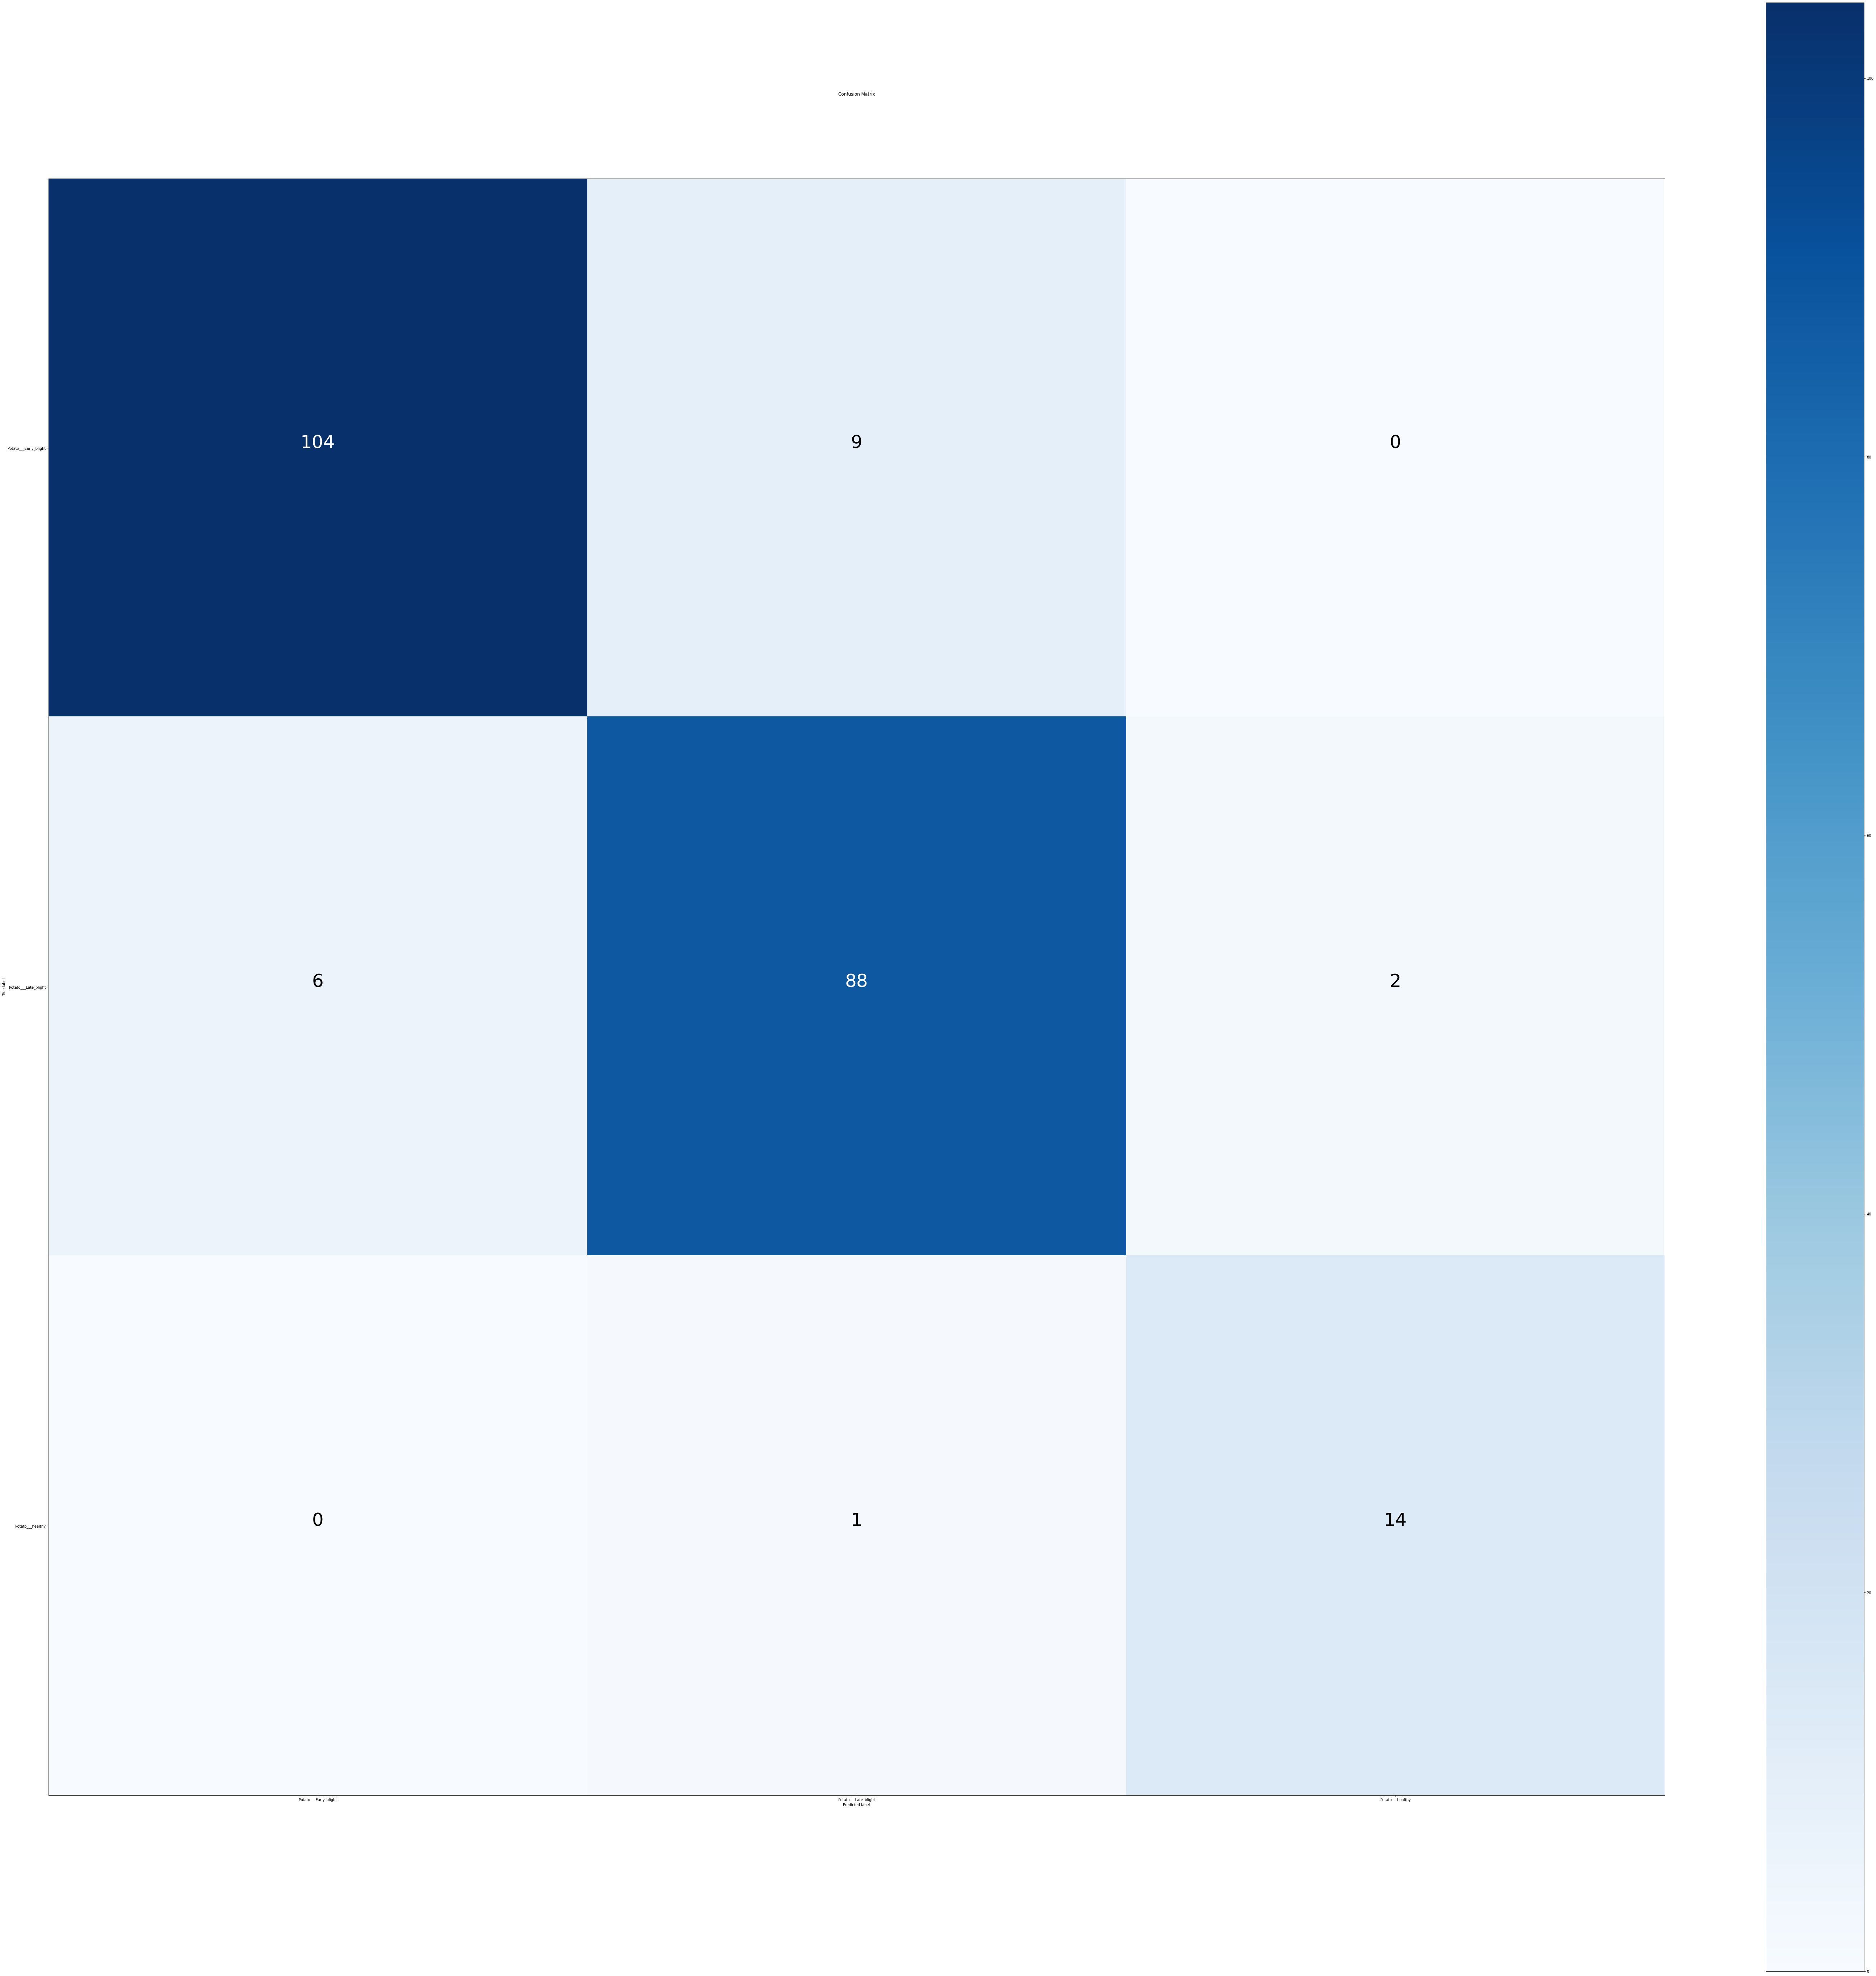

In [230]:
# Plot a confusion matrix with all 224 predictions, ground truth labels and 3 classes
make_confusion_matrix(y_true=labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=50,
                      norm=False,
                      savefig=True)

In [231]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       113
           1       0.90      0.92      0.91        96
           2       0.88      0.93      0.90        15

    accuracy                           0.92       224
   macro avg       0.91      0.92      0.91       224
weighted avg       0.92      0.92      0.92       224



In [232]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9454545454545454,
  'recall': 0.9203539823008849,
  'f1-score': 0.9327354260089686,
  'support': 113},
 '1': {'precision': 0.8979591836734694,
  'recall': 0.9166666666666666,
  'f1-score': 0.9072164948453607,
  'support': 96},
 '2': {'precision': 0.875,
  'recall': 0.9333333333333333,
  'f1-score': 0.9032258064516129,
  'support': 15},
 'accuracy': 0.9196428571428571,
 'macro avg': {'precision': 0.9061379097093383,
  'recall': 0.9234513274336283,
  'f1-score': 0.9143925757686474,
  'support': 224},
 'weighted avg': {'precision': 0.9203814520938245,
  'recall': 0.9196428571428571,
  'f1-score': 0.9198226506292067,
  'support': 224}}

In [233]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Potato___Early_blight': 0.9327354260089686,
 'Potato___Late_blight': 0.9072164948453607,
 'Potato___healthy': 0.9032258064516129}

In [234]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,Potato___Early_blight,0.932735
1,Potato___Late_blight,0.907216
2,Potato___healthy,0.903226


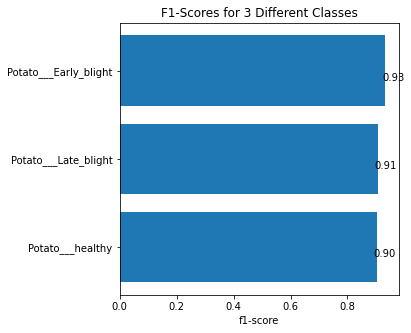

In [235]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 3 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Using Transfer Learning for Building Model

In [236]:
### Model TL: Building a transfer learning model using the Keras Functional API

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input_layer")

x = rescale_resize_layer(inputs)
x = data_augmentation_layer(inputs)

# 4. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)

# Check data shape after passing it to the base_model
print(f"Shape after base_model : {x.shape}")

# 5. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="Output_Layer")(x)

# 7. Combine the outputs and the inputs into a model
model_tl = tf.keras.models.Model(inputs=inputs, outputs=outputs)

Shape after base_model : (None, 8, 8, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [237]:
# 8. Compile the model
model_tl.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer="adam",
                metrics=["accuracy"])

In [238]:
model_tl.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [239]:
# 9. Fit the Model (we use less steps for validation so it's faster)
history1 = model_tl.fit(train_data,
                        epochs=8,
                        validation_data=val_data,
                        batch_size=BATCH_SIZE)

Epoch 1/8
54/54 [==============================] - 154s 3s/step - loss: 0.6104 - accuracy: 0.7824 - val_loss: 0.3314 - val_accuracy: 0.9062
Epoch 2/8
54/54 [==============================] - 143s 3s/step - loss: 0.2421 - accuracy: 0.9340 - val_loss: 0.1909 - val_accuracy: 0.9598
Epoch 3/8
54/54 [==============================] - 147s 3s/step - loss: 0.1549 - accuracy: 0.9734 - val_loss: 0.1385 - val_accuracy: 0.9598
Epoch 4/8
54/54 [==============================] - 146s 3s/step - loss: 0.1205 - accuracy: 0.9769 - val_loss: 0.1078 - val_accuracy: 0.9688
Epoch 5/8
54/54 [==============================] - 145s 3s/step - loss: 0.0954 - accuracy: 0.9826 - val_loss: 0.0906 - val_accuracy: 0.9777
Epoch 6/8
54/54 [==============================] - 147s 3s/step - loss: 0.0822 - accuracy: 0.9850 - val_loss: 0.0763 - val_accuracy: 0.9866
Epoch 7/8
54/54 [==============================] - 149s 3s/step - loss: 0.0664 - accuracy: 0.9896 - val_loss: 0.0651 - val_accuracy: 0.9866
Epoch 8/8
54/54 [===

In [240]:
history1.history['accuracy']

[0.7824074029922485,
 0.9340277910232544,
 0.9733796119689941,
 0.9768518805503845,
 0.9826388955116272,
 0.9849537014961243,
 0.9895833134651184,
 0.9918981194496155]

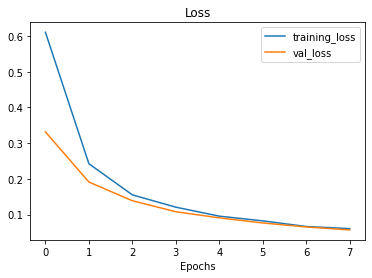

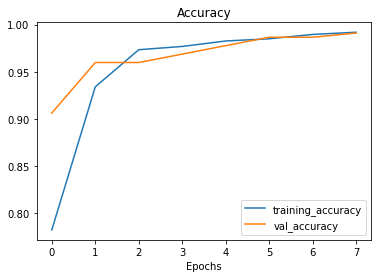

In [241]:
plot_loss_curves(history1)

In [242]:
results_tl = model_tl.evaluate(test_data)
results_tl

7/7 [==============================] - 13s 2s/step - loss: 0.0405 - accuracy: 0.9955


[0.04049808159470558, 0.9955357313156128]

In [243]:
tf.keras.models.save_model(model_tl, "transferLearning_model.h5")

C:\Users\USER\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [244]:
model_tl.save_weights("transferLearning_model_weights.h5")

In [245]:
model_tl.load_weights("transferLearning_model_weights.h5")

In [246]:
results_tl_loaded = model_tl.evaluate(test_data)
results_tl_loaded

7/7 [==============================] - 14s 2s/step - loss: 0.0405 - accuracy: 0.9955


[0.04049808159470558, 0.9955357313156128]

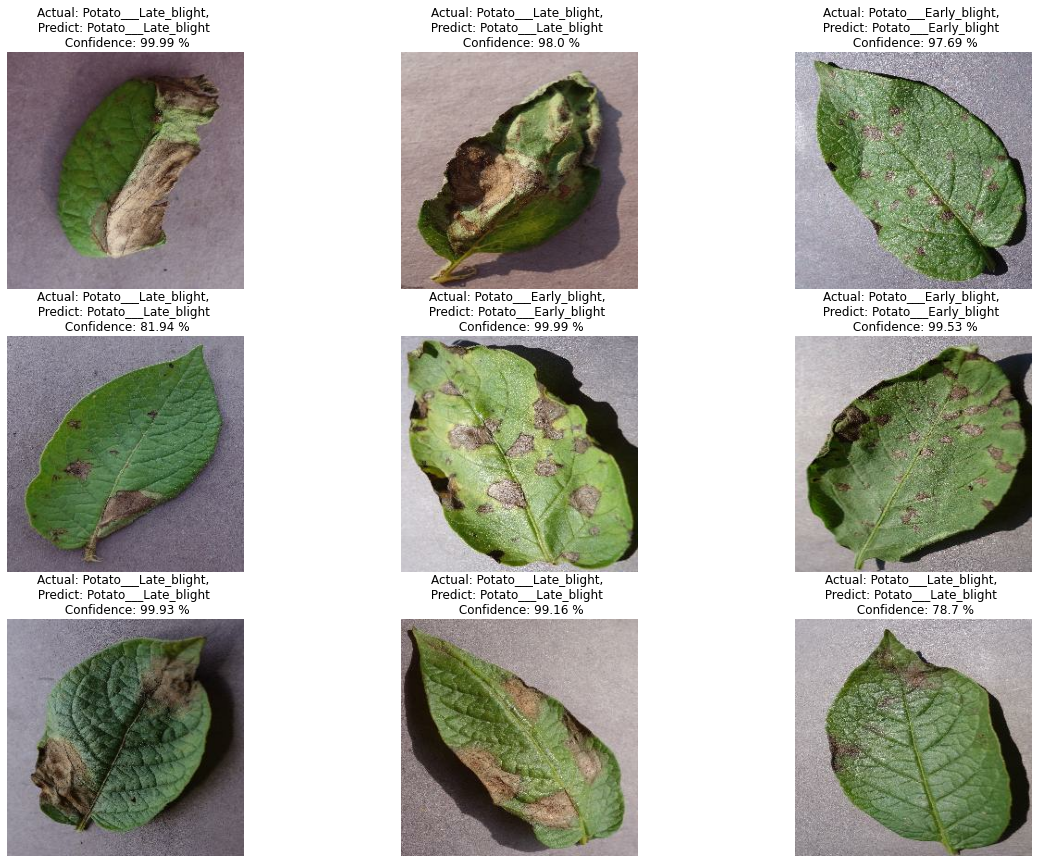

In [249]:
# Make Some Predictions vor random samples from test_data
plt.figure(figsize=(20, 20))
for image_batch, label_batch in test_data.take(1):
    for i in range(9):
        image, label = image_batch[i], label_batch[i]
        pred, confid = predict(img=image, model=model_tl)
        plt.subplot(4, 3, i+1)
        plt.imshow(image.numpy().astype("uint16"))
        plt.title(f"Actual: {class_names[label]}, \n Predict: {pred}  \n Confidence: {confid} %")
        plt.axis("off")

In [247]:
def predict(img, model):
    img = tf.expand_dims(img, axis=0)
    predict_prob = model.predict(img)
    predict_class = class_names[tf.argmax(predict_prob[0], axis=0).numpy()]
    confidence = np.round(np.max(predict_prob[0]) * 100, 2) 
    
    return predict_class, confidence

In [248]:
predict(img=image_batch[17], model=model_tl)

('Potato___healthy', 92.92)

In [250]:
model_version = 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


In [251]:
model_version = "Trasnfer_Learning"
model_tl.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/Trasnfer_Learning\assets


C:\Users\USER\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
